# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# Import libraries
import os
from time import time
from glob import glob

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt                        
%matplotlib inline
import seaborn as sns
sns.set_style('white')

import cv2                
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# the following import is required for training to be robust to truncated images
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#from tqdm.notebook import tqdm
from tqdm import tqdm

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Cuda is available')
#from workspace_utils import active_session
# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

Cuda is available
There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


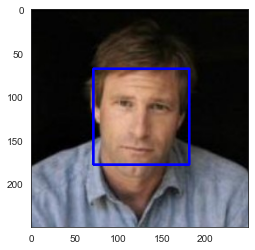

In [2]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 96 out of 100 or about 96% was correctly detected faces in human images
- 18 out of 100 or about 18% was uncorrectly detected faces in dog images

In [4]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def face_detection_test(images):
    c = 0
    l = len(images)
    for img in images:
        c += face_detector(img)
    return c, l

In [5]:
c_human, l_human = face_detection_test(human_files_short)

In [6]:
c_dog, l_dog = face_detection_test(dog_files_short)

In [7]:
print(f'{c_human} out of {l_human} or about {c_human/l_human:.0%} was correctly detected faces in human images')
print(f'{c_dog} out of {l_dog} or about {c_dog/l_dog:.0%} was uncorrectly detected faces in dog images')

96 out of 100 or about 96% was correctly detected faces in human images
18 out of 100 or about 18% was uncorrectly detected faces in dog images


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\aghar/.cache\torch\hub\checkpoints\vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # First load the image
    img = Image.open(img_path) #.convert('RGB')
    
    # Setup the normalizer
    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    
    # Setting up image preprocessor
    img_transform = transforms.Compose([transforms.Resize((224, 224)), # Resize the image to 244x244
                                        transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                        normalizer]) # Apply the normalizer
    
    # Apply the preprocessing to the image before passing it to our model 
    # and add a dummy axis as the model expect a batch of images not a single image
    preproccessed_img = img_transform(img)[:3,:,:].unsqueeze(0)
    
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()

    # move imag to GPU if CUDA is available
    if use_cuda:
        preproccessed_img = preproccessed_img.cuda()
    
    # Use VGG16 to predict the class of the image
    pred = VGG16(preproccessed_img)
    # Move the prediction to cpu and convert it to numpy array and return the index of the class of highest probability
    pred = pred.cpu().data.numpy().argmax()
    
    return pred # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    # Use VGG16_predict to get the class index
    pred_idx = VGG16_predict(img_path)
    
    # Return True if the class is between 151 and 268 inclusive
    result = pred_idx >=151 and pred_idx <=268
    
    return result # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- 0 out of 100 or about 0% was uncorrectly detected dogs in human images
- 95 out of 100 or about 95% was correctly detected dogs in dog images

In [12]:
# Helper function to test the dog detector
def dog_detection_test(images):
    c = 0
    l = len(images)
    for img in images:
        if dog_detector(img):
            c += 1
    return c, l

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Test the model in human images
detected_human, len_human = dog_detection_test(human_files_short)

# Test the model in dog images
detected_dog, len_dog = dog_detection_test(dog_files_short)

# Print the results
print(f'{detected_human} out of {len_human} or about {detected_human/len_human:.0%} was uncorrectly detected dogs in human images')
print(f'{detected_dog} out of {len_dog} or about {detected_dog/len_dog:.0%} was correctly detected dogs in dog images')

0 out of 100 or about 0% was uncorrectly detected dogs in human images
94 out of 100 or about 94% was correctly detected dogs in dog images


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

|Yellow Labrador | Chocolate Labrador | Black Labrador|
| :-: | :-: | :-: |
| <img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220"> |

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define training , validation and test data directories
data_dir = 'data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')


# Setup the normalizer
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Transforming the data and applying image augmentation for training dataset
train_transform = transforms.Compose([transforms.Resize((224, 224)), # Resize the image to 256x256
                                      transforms.RandomRotation(30), # Randomly rotate the image in the range of 30 degree
                                      transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
                                      transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                      normalizer]) # Apply the normalizer

# Transformation for test and validation datasets
val_test_transform = transforms.Compose([transforms.Resize((224, 224)), # # Resize the image to 256x256
                                         transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                         normalizer]) # Apply the normalizer


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# print out some data stats
print(f'Number of training images: {len(train_data)}')
print(f'Number of validation images: {len(valid_data)}')
print(f'Number of test images: {len(test_data)}')

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

loaders_scratch = {'train': train_loader,
                   'valid': valid_loader, 
                   'test': test_loader}

Number of training images: 6680
Number of validation images: 835
Number of test images: 836


In [16]:
# Data frame for number of classes accros train dataset
num_train_classes = pd.DataFrame.from_dict(dict(Counter(train_data.targets)), orient='index').reset_index()
num_train_classes.columns = ['class', 'counts']

# Data frame for number of classes accros validation dataset
num_val_classes = pd.DataFrame.from_dict(dict(Counter(valid_data.targets)), orient='index').reset_index()
num_val_classes.columns = ['class', 'counts']

# Data frame for number of classes accros test dataset
num_test_classes = pd.DataFrame.from_dict(dict(Counter(test_data.targets)), orient='index').reset_index()
num_test_classes.columns = ['class', 'counts']

In [17]:
# Display Datasets summary statistics
print(f'Train Dataset\n{num_train_classes["counts"].describe()}\n\n\
Validation Dataset\n{num_val_classes["counts"].describe()}\n\n\
Test Dataset\n{num_test_classes["counts"].describe()}')

Train Dataset
count    133.000000
mean      50.225564
std       11.863885
min       26.000000
25%       42.000000
50%       50.000000
75%       61.000000
max       77.000000
Name: counts, dtype: float64

Validation Dataset
count    133.000000
mean       6.278195
std        1.350384
min        4.000000
25%        6.000000
50%        6.000000
75%        7.000000
max        9.000000
Name: counts, dtype: float64

Test Dataset
count    133.000000
mean       6.285714
std        1.712571
min        3.000000
25%        5.000000
50%        6.000000
75%        8.000000
max       10.000000
Name: counts, dtype: float64


In [18]:
# Helper function to plot the distribution accross classes

def plot_num_classes(dfs_list=[num_train_classes, num_val_classes, num_test_classes], colors=['#00334e', '#40e580']):
    """Ploting the distribution of classes count"""
    
    # List for plot title
    titles = ['Train Dataset', 'Validation Dataset', 'Test Dataset']
    
    
    # Create figure with 2x2 subplots
    fig, axis = plt.subplots(figsize=(20, 20), nrows=3)
    
    # Plotting loops
    # Iterate over axis 
    for i, ax in enumerate(axis.flatten()):
        med = dfs_list[i]['counts'].median()
        ax.plot(dfs_list[i]['counts'], color=colors[1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(y=med, color=colors[0])
        ax.text(x=133/2, y=1.02*med, s=f'Median = {med:.0f}', fontdict={'fontsize': 20, 'color':colors[0]})
        ax.set_title(titles[i] + ' Classes Ditribution', fontdict={'fontsize': 22, 'fontweight':'bold'})
        ax.set_xlabel('Class Number', fontdict={'fontsize': 14})
        ax.set_ylabel('Count', fontdict={'fontsize': 14})
        ax.set_xticks(np.arange(0, 133, 5))
        ax.set_xlim(0)
        ax.set_ylim(0);


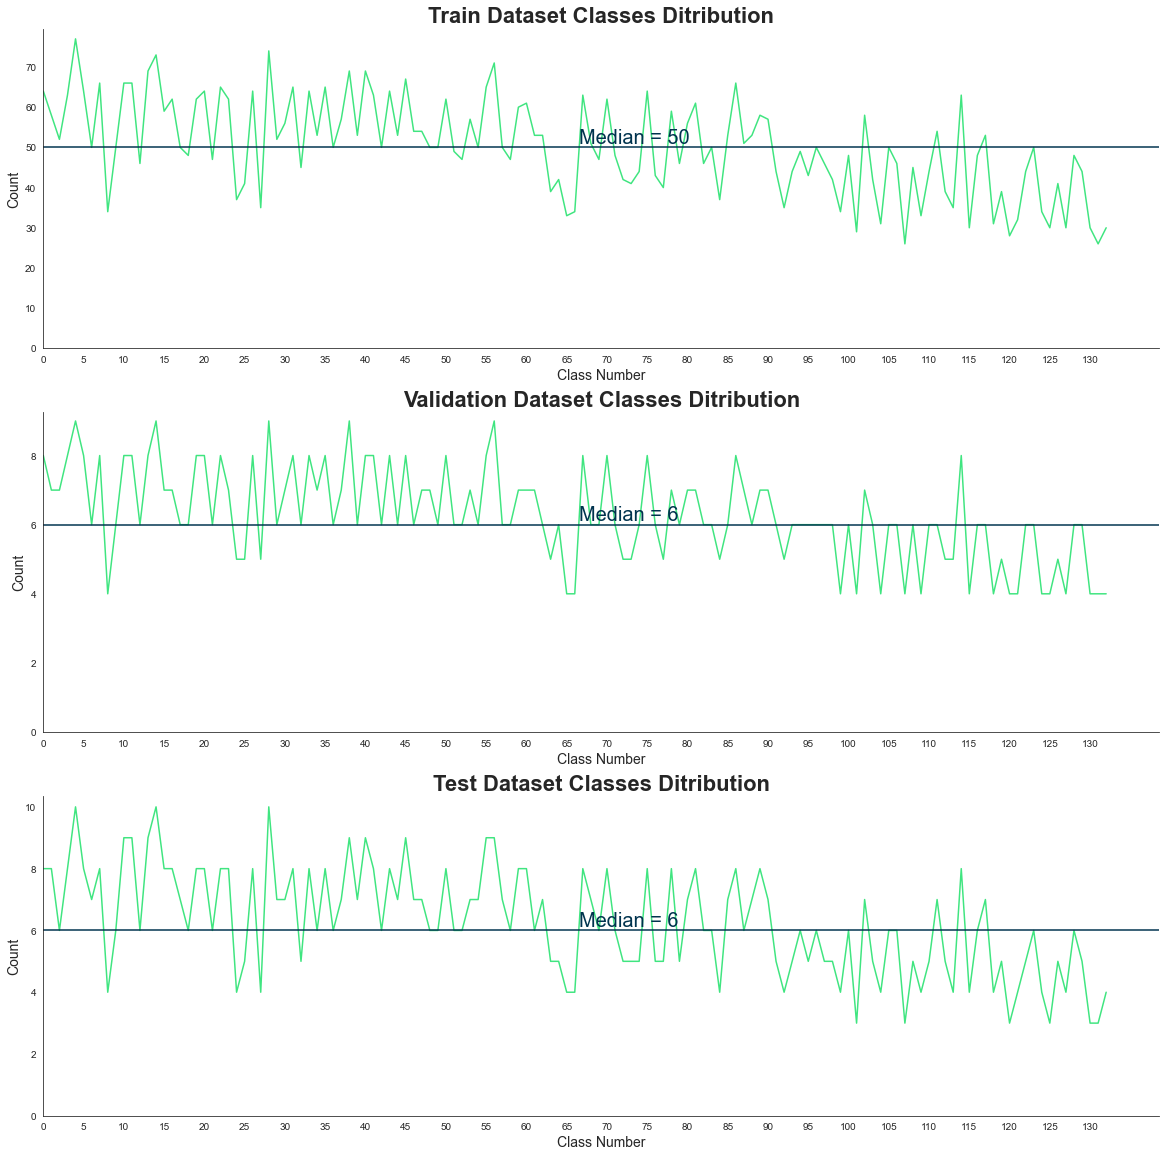

In [19]:
plot_num_classes()

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- I chosed to resize my images to the same size as VGG-16 and reduce the image size to 224x224 and to load the images to the model in batches of size 20 so the input tensor shape would be (20, 224, 224, 3)
- I decided to augment training images only by rondamly cropping and resizing the images , randomly flipping horizontly, and randomly rotating them in range of 30 degrees to avoid overfitting. But for test and validation images i just resized them to the valid input shape.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [20]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)

        # Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(7*7*256, 500)
        self.fc2 = nn.Linear(500, 133) 
        
        # Dropout layer
        self.dropout = nn.Dropout(0.50)
        
        # Batch Normalizing layers for conv layers
        self.conv_bn1 = nn.BatchNorm2d(128)
        self.conv_bn2 = nn.BatchNorm2d(256)
        
        # Batch Normalizing layer for fully connected layers
        self.bn = nn.BatchNorm1d(500)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv_bn1(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv_bn2(self.conv5(x))))
        x = self.dropout(x)
        x = F.relu(self.conv_bn2(self.conv6(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ <br>
For the problem we have here in order to acheive the best accuracy I would have chosed a deeper neural network with much more layers, but for the purpose of this task I chosed the following: 
- 6 Convolutional layers with kernal size (3,3) and same padding with stride of 1 to reserve the same size of the input picture but with different number of channels (32, 64, 64, 128, 256, 256) for each conv layer respectivly.
- And to reduce the computation needed I follow each conv layer witha Max Pooling layer with a kernal size of (2,2) in order to reduce the tensor to half of it's height and width dimention.
- To stable the training I chosed to use Batch Normalization layers for 2 of the conv layers and for the first fully-connected layer.
- To pass the tensor to the fully connected layers I flatten the output of the last conv layer.
- To reduce overfitting I used Dropout layers after each block.
- Finaly I used 2 fully connected layer the last layer with the same output shape as the number of the classes 133.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
# Weight tensor for CrossEntropyLoss
weight = torch.FloatTensor(1/num_train_classes['counts']).cuda()

In [22]:
weight

tensor([0.0156, 0.0172, 0.0192, 0.0159, 0.0130, 0.0156, 0.0200, 0.0152, 0.0294,
        0.0200, 0.0152, 0.0152, 0.0217, 0.0145, 0.0137, 0.0169, 0.0161, 0.0200,
        0.0208, 0.0161, 0.0156, 0.0213, 0.0154, 0.0161, 0.0270, 0.0244, 0.0156,
        0.0286, 0.0135, 0.0192, 0.0179, 0.0154, 0.0222, 0.0156, 0.0189, 0.0154,
        0.0200, 0.0175, 0.0145, 0.0189, 0.0145, 0.0159, 0.0200, 0.0156, 0.0189,
        0.0149, 0.0185, 0.0185, 0.0200, 0.0200, 0.0161, 0.0204, 0.0213, 0.0175,
        0.0200, 0.0154, 0.0141, 0.0200, 0.0213, 0.0167, 0.0164, 0.0189, 0.0189,
        0.0256, 0.0238, 0.0303, 0.0294, 0.0159, 0.0196, 0.0213, 0.0161, 0.0208,
        0.0238, 0.0244, 0.0227, 0.0156, 0.0233, 0.0250, 0.0169, 0.0217, 0.0179,
        0.0164, 0.0217, 0.0200, 0.0270, 0.0189, 0.0152, 0.0196, 0.0189, 0.0172,
        0.0175, 0.0227, 0.0286, 0.0227, 0.0204, 0.0233, 0.0200, 0.0217, 0.0238,
        0.0294, 0.0208, 0.0345, 0.0172, 0.0238, 0.0323, 0.0200, 0.0217, 0.0385,
        0.0222, 0.0303, 0.0227, 0.0185, 

In [23]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss(weight=weight)

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0001, weight_decay=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [24]:
# Train function
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, model_path, summary_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    # Initialize empty lists to track training and validation losses and accuracy for each epoch
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []
    # Start time to calculate the time for training
    train_start = time()
    for epoch in range(1, n_epochs+1):
        with tqdm(total = len(train_data)) as t_epoch_pbar:
            t_epoch_pbar.set_description(f'Epoch {epoch}/{n_epochs}')
            # Start time for epoch
            epoch_start = time()
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0
            train_correct = 0.0
            train_total = 0.0
            valid_correct = 0.0
            valid_total = 0.0
            ###################
            # train the model #
            ###################
            model.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## find the loss and update the model parameters accordingly
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass
                loss.backward()
                # perform a single optimization step to update model parameters
                optimizer.step()
                # update training loss 
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                # convert output probabilities to predicted class
                pred = output.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                train_total += data.size(0)
                # Update the progress bar
                desc = f'Epoch: {epoch}/{n_epochs} - Train loss = {train_loss:.4f} - Train Accuracy = {train_correct/train_total:.2%}'
                t_epoch_pbar.set_description(desc)
                t_epoch_pbar.update(data.shape[0])
            ######################    
            # validate the model #
            ######################
            model.eval()
        with tqdm(total = len(valid_data)) as v_epoch_pbar:
            v_epoch_pbar.set_description(f'Epoch {epoch}/{n_epochs}')
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                # forward pass
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                # convert output probabilities to predicted class
                pred = output.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                valid_total += data.size(0)
                # Update the progress bar
                desc = f'Epoch: {epoch}/{n_epochs} - Valid loss = {valid_loss:.4f} - Valid Accuracy = {valid_correct/(valid_total+1e-10):.2%}'
                v_epoch_pbar.set_description(desc)
                v_epoch_pbar.update(data.shape[0])

            # calculate average losses
            # train_loss = train_loss/len(loaders['train'].dataset)
            # valid_loss = valid_loss/len(loaders['valid'].dataset)    

        # print training/validation statistics 
       # print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\n\
       # Train Accuracy: {:.2f}% ({:.0f}/{:.0f})\tVal Accuracy: {:.2f}% ({:.0f}/{:.0f})\tFinished in: {:.0f} Seconds'.format(
       #     epoch, 
       #     train_loss,
       #     valid_loss,
       #     100. * train_correct / train_total,
       #     train_correct,
       #     train_total,
       #     100. * valid_correct / valid_total,
       #     valid_correct,
       #     valid_total,
       #     time()-epoch_start
       #     ))
        # Add train and valid loss for each epoch to the train_losses and valid_losses lists
        train_losses.append(train_loss.cpu().numpy())
        valid_losses.append(valid_loss.cpu().numpy())
        train_acc.append(100. * train_correct / train_total)
        valid_acc.append(100. * valid_correct / valid_total)
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving the model ...')
            torch.save(model.state_dict(), model_path)
            valid_loss_min = valid_loss
    
    # Save Model Summary to a pandas DF
    print('Saving the model summary ...')
    summary_dict = {
        'epoch': np.arange(1, n_epochs+1, 1),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_acc,
        'valid_acc': valid_acc,
    }
    model_summary = pd.DataFrame(summary_dict)
    # Save the df to csv file
    model_summary.to_csv(summary_path, index=False)
    print(f'Finished Training in: {time()-train_start:.0f} Seconds')
    # return trained model and the model_summary dataframe
    return model, model_summary

In [29]:
# train the model

model_scratch, model_summary = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                                     criterion_scratch, use_cuda, 'models/model_scratch.pt', 'models/model_scratch.csv')

Epoch: 1/10 - Train loss = 2.6880 - Train Accuracy = 33.89%: 100%|█| 6680/6680 
Epoch: 1/10 - Valid loss = 3.3607 - Valid Accuracy = 31.62%: 100%|█| 835/835 [0
Epoch 2/10:   0%|                                     | 0/6680 [00:00<?, ?it/s]

Validation loss decreased (inf --> 3.360670).  Saving the model ...


Epoch: 2/10 - Train loss = 2.6739 - Train Accuracy = 33.97%: 100%|█| 6680/6680 
Epoch: 2/10 - Valid loss = 3.3895 - Valid Accuracy = 33.77%: 100%|█| 835/835 [0
Epoch: 3/10 - Train loss = 2.6655 - Train Accuracy = 34.40%: 100%|█| 6680/6680 
Epoch: 3/10 - Valid loss = 3.2385 - Valid Accuracy = 34.37%: 100%|█| 835/835 [0
Epoch 4/10:   0%|                                     | 0/6680 [00:00<?, ?it/s]

Validation loss decreased (3.360670 --> 3.238466).  Saving the model ...


Epoch: 4/10 - Train loss = 2.6648 - Train Accuracy = 34.69%: 100%|█| 6680/6680 
Epoch: 4/10 - Valid loss = 3.2656 - Valid Accuracy = 34.73%: 100%|█| 835/835 [0
Epoch: 5/10 - Train loss = 2.6510 - Train Accuracy = 34.84%: 100%|█| 6680/6680 
Epoch: 5/10 - Valid loss = 3.2492 - Valid Accuracy = 32.10%: 100%|█| 835/835 [0
Epoch: 6/10 - Train loss = 2.6407 - Train Accuracy = 35.24%: 100%|█| 6680/6680 
Epoch: 6/10 - Valid loss = 3.4781 - Valid Accuracy = 30.66%: 100%|█| 835/835 [0
Epoch: 7/10 - Train loss = 2.6539 - Train Accuracy = 34.99%: 100%|█| 6680/6680 
Epoch: 7/10 - Valid loss = 3.3550 - Valid Accuracy = 33.89%: 100%|█| 835/835 [0
Epoch: 8/10 - Train loss = 2.6345 - Train Accuracy = 34.57%: 100%|█| 6680/6680 
Epoch: 8/10 - Valid loss = 3.1586 - Valid Accuracy = 35.09%: 100%|█| 835/835 [0
Epoch 9/10:   0%|                                     | 0/6680 [00:00<?, ?it/s]

Validation loss decreased (3.238466 --> 3.158564).  Saving the model ...


Epoch: 9/10 - Train loss = 2.6234 - Train Accuracy = 36.24%: 100%|█| 6680/6680 
Epoch: 9/10 - Valid loss = 3.2647 - Valid Accuracy = 31.02%: 100%|█| 835/835 [0
Epoch: 10/10 - Train loss = 2.6351 - Train Accuracy = 35.36%: 100%|█| 6680/6680
Epoch: 10/10 - Valid loss = 3.2699 - Valid Accuracy = 33.53%: 100%|█| 835/835 [

Saving the model summary ...
Finished Training in: 931 Seconds


In [30]:
# Helper function to plot the model summary

def plot_model_summary(model_summary):
    fig, ax = plt.subplots(figsize=(20, 6), ncols=2)
    ax[0].plot(model_summary.train_losses, color='#40e580')
    ax[0].plot(model_summary.valid_losses, color='#00334e')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    #ax[0].spines['left'].set_visible(False)
    ax[0].set_title('Training VS Validation Loss', fontdict={'fontsize': 20, 'fontweight':'bold'})
    ax[0].set_xlabel('Epoch', fontdict={'fontsize': 14})
    ax[0].set_ylabel('Loss', fontdict={'fontsize': 14})
    ax[0].set_ylim(0)
    ax[0].legend(['Training', 'Validation']);

    ax[1].plot(model_summary.train_acc, color='#40e580')
    ax[1].plot(model_summary.valid_acc, color='#00334e')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    #ax[1].spines['left'].set_visible(False)
    ax[1].set_title('Training VS Validation Accuracy', fontdict={'fontsize': 20, 'fontweight':'bold'})
    ax[1].set_xlabel('Epoch', fontdict={'fontsize': 14})
    ax[1].set_ylabel('Accuracy', fontdict={'fontsize': 14})
    ax[1].set_ylim(0)
    ax[1].legend(['Training', 'Validation']);

In [31]:
model_summary = pd.read_csv('models/model_scratch.csv')

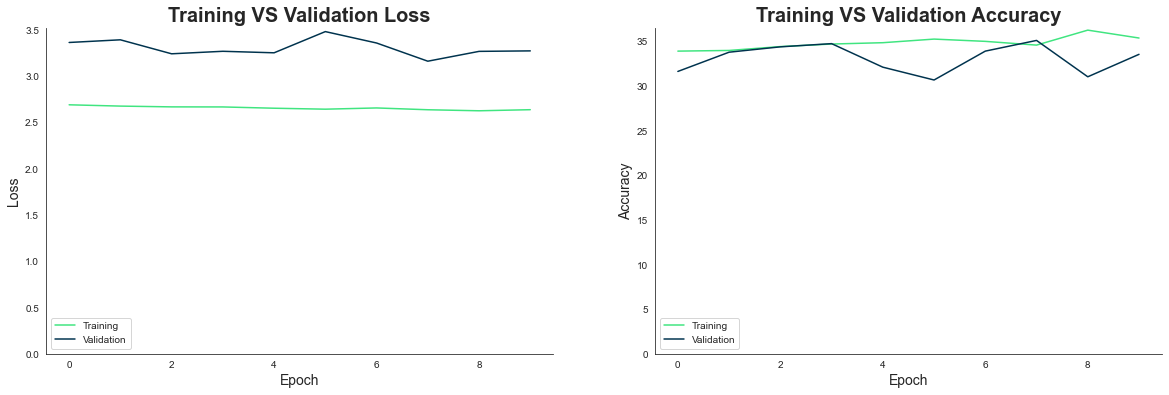

In [32]:
# Plot model scratch summary
plot_model_summary(model_summary)

In [33]:
# load the model that got the best validation loss
model_scratch.load_state_dict(torch.load('models/model_scratch.pt'))

<All keys matched successfully>

In [34]:
# instantiate the CNN
model_scratch_SGD = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_SGD.cuda()
    
# Select loss function for model scratch with SGD with momentum optimizer
criterion_scratch_SGD = nn.CrossEntropyLoss(weight=weight)

# Select optimizer
optimizer_scratch_SGD = optim.SGD(model_scratch_SGD.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

In [37]:
# train the model

model_scratch_SGD, model_summary_SGD = train(100, loaders_scratch, model_scratch_SGD, optimizer_scratch_SGD, 
                                             criterion_scratch_SGD, use_cuda, 'models/model_scratch_SGD.pt', 'models/model_scratch_SGD.csv')


Validation loss decreased (inf --> 4.757198).  Saving the model ...



Validation loss decreased (4.757198 --> 4.669865).  Saving the model ...



Validation loss decreased (4.669865 --> 4.529199).  Saving the model ...



Validation loss decreased (4.529199 --> 4.518350).  Saving the model ...



Validation loss decreased (4.518350 --> 4.506490).  Saving the model ...



Validation loss decreased (4.506490 --> 4.370106).  Saving the model ...



Validation loss decreased (4.370106 --> 4.285180).  Saving the model ...



Validation loss decreased (4.285180 --> 4.280340).  Saving the model ...



Validation loss decreased (4.280340 --> 4.232754).  Saving the model ...



Validation loss decreased (4.232754 --> 4.228972).  Saving the model ...



Validation loss decreased (4.228972 --> 4.181613).  Saving the model ...



Validation loss decreased (4.181613 --> 4.093464).  Saving the model ...



Validation loss decreased (4.093464 --> 4.006299).  Saving the model ...



Validation loss decreased (4.006299 --> 3.986331).  Saving the model ...



Validation loss decreased (3.986331 --> 3.933434).  Saving the model ...



Validation loss decreased (3.933434 --> 3.857942).  Saving the model ...



Validation loss decreased (3.857942 --> 3.846669).  Saving the model ...



Validation loss decreased (3.846669 --> 3.841810).  Saving the model ...



Validation loss decreased (3.841810 --> 3.782327).  Saving the model ...



Saving the model summary ...
Finished Training in: 13401 Seconds


In [35]:
model_summary_SGD = pd.read_csv('models/model_scratch_SGD.csv')

In [36]:
# load the model that got the best validation accuracy
model_scratch_SGD.load_state_dict(torch.load('models/model_scratch_SGD.pt'))

<All keys matched successfully>

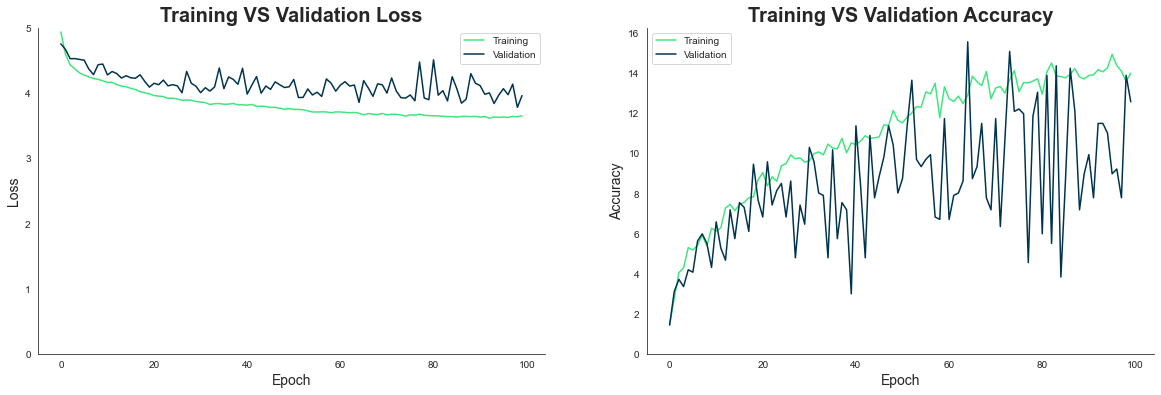

In [37]:
# Plot model scratch with SGD summary
plot_model_summary(model_summary_SGD)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [38]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [39]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.182212


Test Accuracy: 37% (310/836)


In [40]:
# Test Model SGD
test(loaders_scratch, model_scratch_SGD, criterion_scratch_SGD, use_cuda)

Test Loss: 3.792562


Test Accuracy: 13% (117/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [35]:
## TODO: Specify data loaders
# define training , validation and test data directories
data_dir = 'data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')


# Setup the normalizer
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Transforming the data and applying image augmentation for training dataset
train_transform = transforms.Compose([transforms.Resize((224, 224)), # Resize the image to 256x256
                                      transforms.RandomRotation(30), # Randomly rotate the image in the range of 30 degree
                                      transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
                                      transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                      normalizer]) # Apply the normalizer

# Transformation for test and validation datasets
val_test_transform = transforms.Compose([transforms.Resize((224, 224)), # # Resize the image to 256x256
                                         transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                         normalizer]) # Apply the normalizer


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# print out some data stats
print(f'Number of training images: {len(train_data)}')
print(f'Number of validation images: {len(valid_data)}')
print(f'Number of test images: {len(test_data)}')

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)


## TODO: Specify data loaders
loaders_transfer = {'train': train_loader,
                    'valid': valid_loader, 
                    'test': test_loader}

Number of training images: 6680
Number of validation images: 835
Number of test images: 836


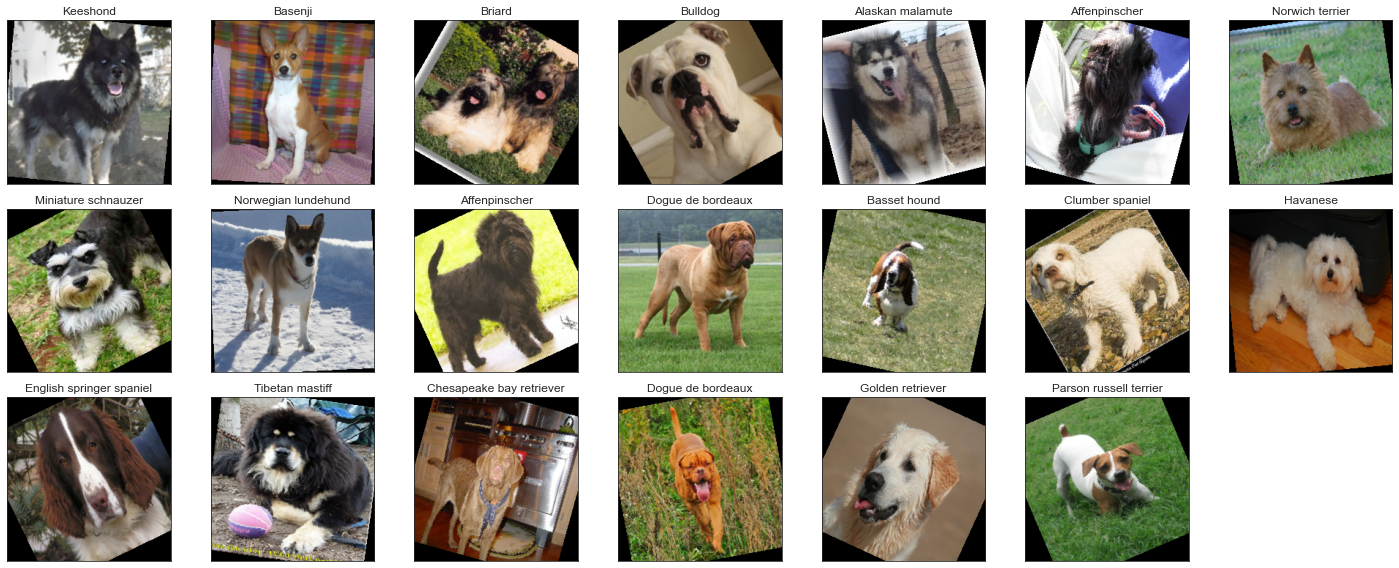

In [36]:
# Get the class names for plotting
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
# Get a batch of training data
inputs, classes = next(iter(loaders_transfer['train']))

# Plot a batch of preprocessed images
fig, axis = plt.subplots(figsize=(20, 8), nrows=3, ncols=7, tight_layout=True)
axis = axis.flatten()
i = 0
for ax, label in zip(axis, classes): 
    image = inputs[i].to("cpu").clone().detach() # Colne the input tensor and move it to cpu
    image = image.numpy().squeeze() # Convert tensot to numpy array and squeez the 1st dimintion 
    image = image.transpose(1, 2, 0) # Reshape the image array to (height, width, channels)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # Retain the colors again
    image = image.clip(0, 1) # Clip the image values between 0 and 1 
    
    # Display the images
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.set_xticks([]); ax.set_yticks([])
    i+=1

# Delete the last axis in the figure
fig.delaxes(axis[20]);

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [37]:
## TODO: Specify model architecture 

# define VGG16 model
model_transfer = models.vgg16(pretrained=True)

print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
# Change the numper of output features for the final layer to the number of classes
model_transfer.classifier[6] = nn.Linear(4096, 133)                        
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
# check if CUDA is available
use_cuda = torch.cuda.is_available()
    
# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
for p in model_transfer.parameters():
    if p.requires_grad:
         print(p.name, p.data.shape)

None torch.Size([4096, 25088])
None torch.Size([4096])
None torch.Size([4096, 4096])
None torch.Size([4096])
None torch.Size([133, 4096])
None torch.Size([133])


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- For our image classification problem here I choses to go with VGG-16 pretrained model and freez the parameters for the features extraction convolutional layers and just train the last fully connected layers to out a prediction for our 133 classes.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [88]:
dict_c = {}
for dir in os.listdir('/data/dog_images/train'):
    class_num = dir.split('.')[0]
    img_count = len(os.listdir('/data/dog_images/train/' + dir))
    dict_c[int(class_num)] = img_count
    

In [89]:
num_train_classes = pd.DataFrame.from_dict(dict_c, orient='index').reset_index()
num_train_classes.columns = ['class', 'counts']
num_train_classes = num_train_classes.sort_values('class').reset_index()

In [40]:
# Weight tensor for CrossEntropyLoss
weight = torch.FloatTensor(1/num_train_classes['counts']).cuda()

In [41]:
criterion_transfer = nn.CrossEntropyLoss(weight=weight)
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr= 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [92]:
# train the model
n_epochs = 100

model_transfer, model_transfer_summary = train(n_epochs, loaders_transfer, model_transfer,
                       optimizer_transfer, criterion_transfer, use_cuda,
                       'models/model_transfer.pt', 'models/model_transfer.csv')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('models/model_transfer.pt'))

Epoch: 1/100 - Train loss = 2.0813 - Train Accuracy = 49.10%: 100%|██████████| 6680/6680 [03:51<00:00, 28.86it/s]
Epoch: 1/100 - Valid loss = 0.8033 - Valid Accuracy = 77.13%: 100%|██████████| 835/835 [00:26<00:00, 32.51it/s]


Validation loss decreased (inf --> 0.803305).  Saving the model ...


Epoch: 2/100 - Train loss = 1.0609 - Train Accuracy = 69.85%: 100%|██████████| 6680/6680 [03:51<00:00, 28.12it/s]
Epoch: 2/100 - Valid loss = 0.6969 - Valid Accuracy = 79.04%: 100%|██████████| 835/835 [00:26<00:00, 32.98it/s]


Validation loss decreased (0.803305 --> 0.696855).  Saving the model ...


Epoch: 3/100 - Train loss = 0.8641 - Train Accuracy = 74.46%: 100%|██████████| 6680/6680 [03:51<00:00, 29.94it/s]
Epoch: 3/100 - Valid loss = 0.6212 - Valid Accuracy = 81.68%: 100%|██████████| 835/835 [00:26<00:00, 32.88it/s]


Validation loss decreased (0.696855 --> 0.621159).  Saving the model ...


Epoch: 4/100 - Train loss = 0.7465 - Train Accuracy = 77.78%: 100%|██████████| 6680/6680 [03:51<00:00, 26.44it/s]
Epoch: 4/100 - Valid loss = 0.5521 - Valid Accuracy = 83.11%: 100%|██████████| 835/835 [00:26<00:00, 33.21it/s]


Validation loss decreased (0.621159 --> 0.552091).  Saving the model ...


Epoch: 5/100 - Train loss = 0.6444 - Train Accuracy = 79.52%: 100%|██████████| 6680/6680 [03:51<00:00, 31.03it/s]
Epoch: 5/100 - Valid loss = 0.5701 - Valid Accuracy = 83.71%: 100%|██████████| 835/835 [00:26<00:00, 32.73it/s]
Epoch: 6/100 - Train loss = 0.6025 - Train Accuracy = 81.09%: 100%|██████████| 6680/6680 [03:51<00:00, 27.93it/s]
Epoch: 6/100 - Valid loss = 0.5484 - Valid Accuracy = 84.19%: 100%|██████████| 835/835 [00:26<00:00, 33.40it/s]


Validation loss decreased (0.552091 --> 0.548389).  Saving the model ...


Epoch: 7/100 - Train loss = 0.5205 - Train Accuracy = 83.92%: 100%|██████████| 6680/6680 [03:50<00:00, 24.44it/s]
Epoch: 7/100 - Valid loss = 0.5468 - Valid Accuracy = 85.39%: 100%|██████████| 835/835 [00:26<00:00, 32.80it/s]


Validation loss decreased (0.548389 --> 0.546757).  Saving the model ...


Epoch: 8/100 - Train loss = 0.4488 - Train Accuracy = 85.91%: 100%|██████████| 6680/6680 [03:50<00:00, 27.84it/s]
Epoch: 8/100 - Valid loss = 0.4954 - Valid Accuracy = 86.83%: 100%|██████████| 835/835 [00:26<00:00, 33.41it/s]


Validation loss decreased (0.546757 --> 0.495387).  Saving the model ...


Epoch: 9/100 - Train loss = 0.4297 - Train Accuracy = 85.99%: 100%|██████████| 6680/6680 [03:51<00:00, 28.69it/s]
Epoch: 9/100 - Valid loss = 0.5101 - Valid Accuracy = 86.23%: 100%|██████████| 835/835 [00:26<00:00, 32.95it/s]
Epoch: 10/100 - Train loss = 0.3914 - Train Accuracy = 87.02%: 100%|██████████| 6680/6680 [03:50<00:00, 30.31it/s]
Epoch: 10/100 - Valid loss = 0.5278 - Valid Accuracy = 84.55%: 100%|██████████| 835/835 [00:26<00:00, 33.43it/s]
Epoch: 11/100 - Train loss = 0.3599 - Train Accuracy = 88.67%: 100%|██████████| 6680/6680 [03:50<00:00, 31.01it/s]
Epoch: 11/100 - Valid loss = 0.5111 - Valid Accuracy = 85.63%: 100%|██████████| 835/835 [00:26<00:00, 33.19it/s]
Epoch: 12/100 - Train loss = 0.3352 - Train Accuracy = 89.03%: 100%|██████████| 6680/6680 [03:51<00:00, 30.84it/s]
Epoch: 12/100 - Valid loss = 0.5113 - Valid Accuracy = 85.87%: 100%|██████████| 835/835 [00:26<00:00, 33.06it/s]
Epoch: 13/100 - Train loss = 0.3126 - Train Accuracy = 89.78%: 100%|██████████| 6680/6680 

Saving the model summary ...
Finished Training in: 25786 Seconds


In [42]:
model_transfer.load_state_dict(torch.load('models/model_transfer.pt'))

<All keys matched successfully>

In [43]:
model_transfer_summary = pd.read_csv('models/model_transfer.csv')

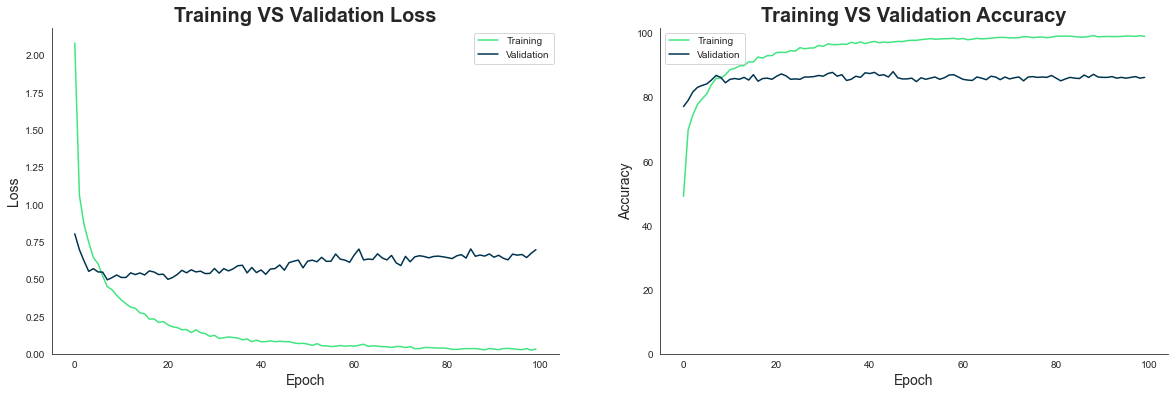

In [44]:
plot_model_summary(model_transfer_summary)

## Comparing the 3 model performance Loss Vs Accuracy

In [45]:
# Helper function to comparer models summary

def plot_compare_models_summary(dfs_list=[model_summary, model_summary_SGD, model_transfer_summary],
                                legend_list=['Scratch Model', 'Scratch SGD', 'Transfer Model'],
                                colors=['#40e580', '#00334e', '#e52060']):
    """Ploting the training summary of models"""
    
    # List for plot title
    titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
    # List for y labels
    ylabels = ['Loss', 'Loss', 'Accuracy', 'Accuracy']
    
    # List for columns to plot
    cols = dfs_list[0].columns
    
    # Create figure with 2x2 subplots
    fig, axis = plt.subplots(figsize=(20, 12), nrows=2, ncols=2)
    
    # Plotting loops
    # Iterate over axis 
    for i, ax in enumerate(axis.flatten()):
        # Iterate over dfs
        for c, df in enumerate(dfs_list):
            ax.plot(df[cols[i+1]], color=colors[c])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(titles[i], fontdict={'fontsize': 20, 'fontweight':'bold'})
        ax.set_xlabel('Epoch', fontdict={'fontsize': 14})
        ax.set_ylabel(ylabels[i], fontdict={'fontsize': 14})
        ax.set_ylim(0)
        ax.legend(legend_list);
    
    fig.text(.3, 0.95, 'Training and Validation Loss and Accuracy', fontdict={'fontsize':24, 'fontweight':'bold'})


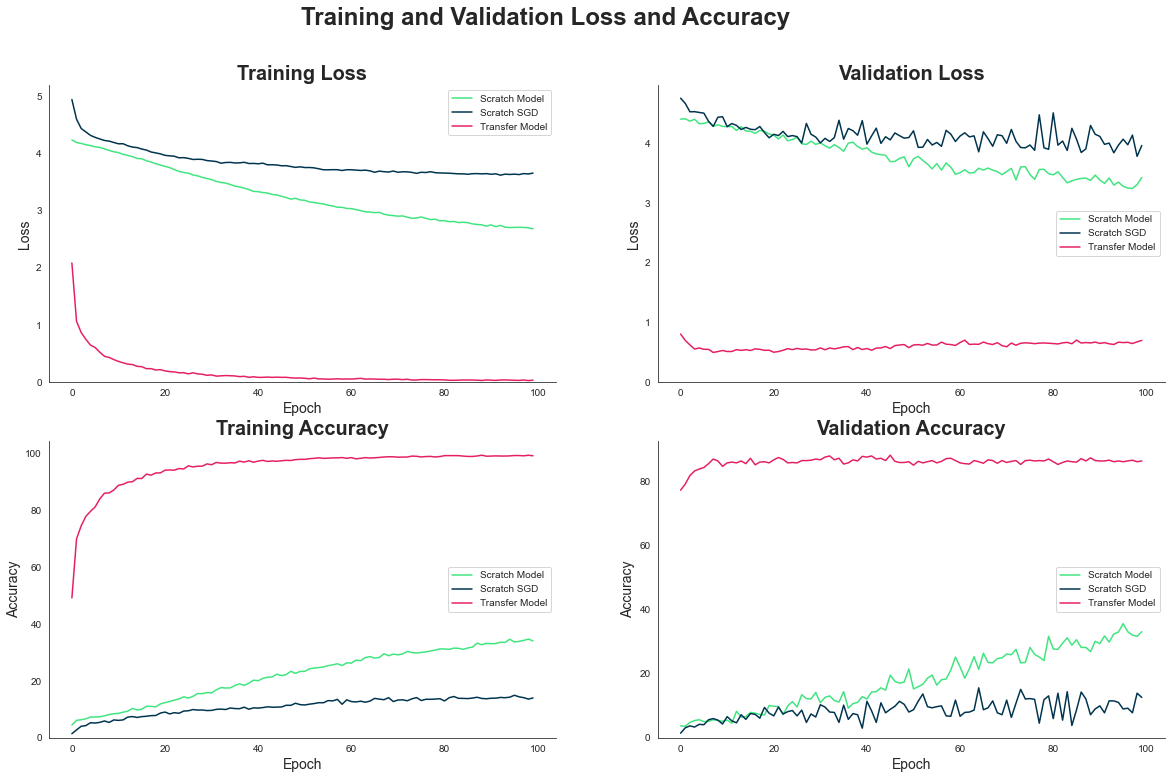

In [46]:
plot_compare_models_summary(dfs_list=[model_summary, model_summary_SGD, model_transfer_summary],
                            legend_list=['Scratch Model', 'Scratch SGD', 'Transfer Model'],
                            colors=['#40e580', '#00334e', '#e52060'])

In [47]:
# Test function to test the accuracy of the model over each class
def test_classes(loaders, model, criterion, use_cuda):

    # monitor test loss 
    test_loss = 0.
    
    # Monitor Target and predictions
    targets = []
    predictions = []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # Append batch predictions and targets to predictions and targets lists
        predictions.append(pred.cpu().numpy())
        targets.append(target.data.view_as(pred).cpu().numpy())
    
    # Concatenate the lists of numpy arrays to 1d numpy array
    predictions = np.concatenate(predictions, axis=0).squeeze() 
    targets = np.concatenate(targets, axis=0).squeeze()
    
    # Compare targets and predictions
    results = predictions == targets
    
    # Create dictionary for the data frame
    df_dict = {
        'target':targets.tolist(),
        'predicted':predictions.tolist(),
        'result':results.tolist()
    }
    
    # Create a data frame to hold the results
    df_results = pd.DataFrame(df_dict)
    
    # Calculate Accuracy
    accuracy = accuracy_score(df_results.target, df_results.predicted)    
    
    # Print test loss and accuracy
    print('Test Loss: {:.6f}\nTest Accuracy: {:.2%}'.format(test_loss.cpu().numpy(), accuracy))

    return df_results

In [48]:
predictions_df = test_classes(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.636054
Test Accuracy: 83.01%


In [49]:
predictions_df

target  predicted  result
0         0          0    True
1         0          0    True
2         0          0    True
3         0          0    True
4         0          0    True
..      ...        ...     ...
831     131        131    True
832     132        132    True
833     132        126   False
834     132        126   False
835     132        132    True

[836 rows x 3 columns]

In [73]:
predictions_count = predictions_df
predictions_count['count'] = 1
predictions_count = predictions_count.groupby(['target', 'predicted', 'result']).sum().reset_index()

In [74]:
predictions_count

target  predicted  result  count
0         0          0    True      7
1         0         98   False      1
2         1          1    True      7
3         1         61   False      1
4         2          2    True      6
..      ...        ...     ...    ...
241     130         72   False      1
242     130        130    True      2
243     131        131    True      3
244     132        126   False      2
245     132        132    True      2

[246 rows x 4 columns]

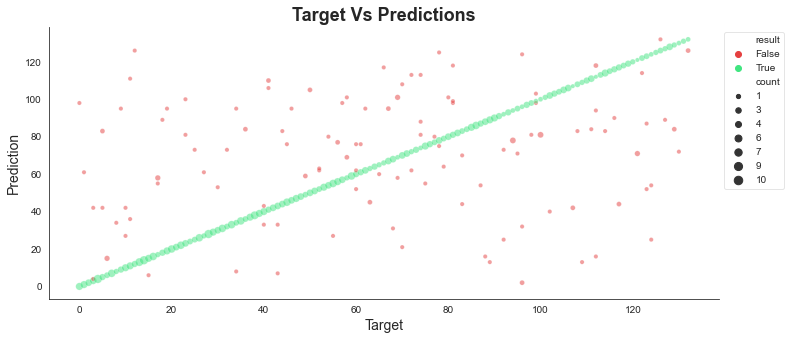

In [92]:
# Plotting the target vs prediction for the final model

fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(data=predictions_count,
                x='target',
                y='predicted',
                hue='result',
                size='count',
                palette=['#e54040', '#40e580'],
                alpha=0.5)
sns.despine()
plt.title('Target Vs Predictions', fontdict={'fontsize': 18, 'fontweight':'bold'})
plt.xlabel('Target', fontdict={'fontsize': 14})
plt.ylabel('Prediction', fontdict={'fontsize': 14})
plt.legend(framealpha=0.5, bbox_to_anchor=(1, 1), loc='upper left');

In [50]:
grouped_df = predictions_df[['target', 'result']].groupby('target').mean()
grouped_df.columns = ['accuracy']

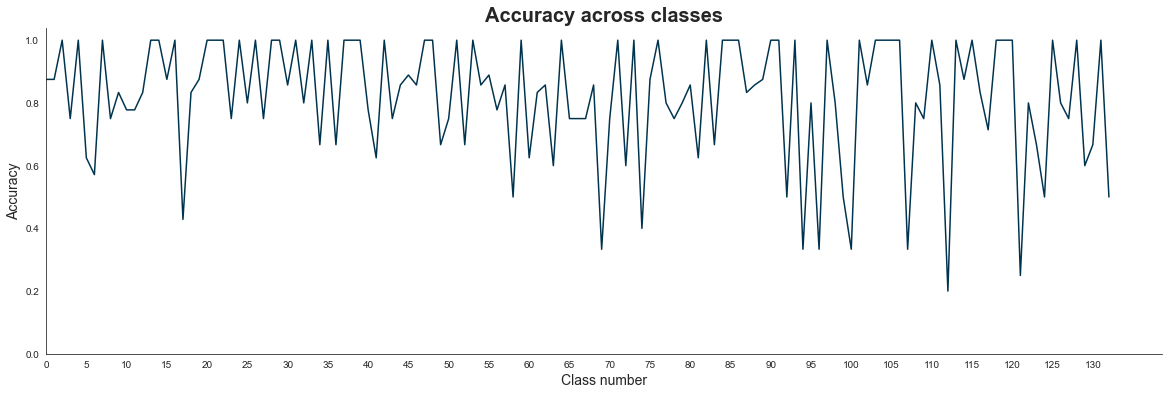

In [51]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(grouped_df, color='#00334e')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Accuracy across classes', fontdict={'fontsize': 20, 'fontweight':'bold'})
ax.set_xlabel('Class number', fontdict={'fontsize': 14})
ax.set_ylabel('Accuracy', fontdict={'fontsize': 14})
ax.set_xticks(np.arange(0, 133, 5))
ax.set_xlim(0)
ax.set_ylim(0);

In [52]:
classes_accuracy = grouped_df
classes_accuracy.index = class_names
classes_accuracy

accuracy
Affenpinscher                0.875000
Afghan hound                 0.875000
Airedale terrier             1.000000
Akita                        0.750000
Alaskan malamute             1.000000
...                               ...
Tibetan mastiff              1.000000
Welsh springer spaniel       0.600000
Wirehaired pointing griffon  0.666667
Xoloitzcuintli               1.000000
Yorkshire terrier            0.500000

[133 rows x 1 columns]

In [53]:
# Display the lowest 5 classes accuracy
classes_accuracy.sort_values('accuracy').head()

accuracy
Old english sheepdog  0.200000
Pointer               0.250000
German pinscher       0.333333
Kuvasz                0.333333
Lakeland terrier      0.333333

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [54]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.636054


Test Accuracy: 83% (694/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [55]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # First load the image
    img = Image.open(img_path) #.convert('RGB')
    
    # Setup the normalizer
    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    
    # Setting up image preprocessor
    img_transform = transforms.Compose([transforms.Resize((224, 224)), # Resize the image to 244x244
                                        transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                        normalizer]) # Apply the normalizer
    
    # Apply the preprocessing to the image before passing it to our model 
    # and add a dummy axis as the model expect a batch of images not a single image
    preproccessed_img = img_transform(img)[:3,:,:].unsqueeze(0)
    
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()

    # move imag to GPU if CUDA is available
    if use_cuda:
        preproccessed_img = preproccessed_img.cuda()
    
    # Use VGG16 to predict the class of the image
    pred = model_transfer(preproccessed_img)
    # Move the prediction to cpu and convert it to numpy array and return the index of the class of highest probability
    pred = pred.cpu().data.numpy().argmax()
    
    return class_names[pred], pred # return class name and index

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [56]:
dirs = os.listdir('data/dog_images/test')
breed_images = []
for dir in dirs:
    files = os.listdir('data/dog_images/test/' + dir)
    breed_images.append(os.path.join('data/dog_images/test/' + dir + '/', files[0]))

In [57]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    
    # Use dog_detector to see if there is a dog in the picture first
    if dog_detector(img_path):
        # get the dog breed
        breed, index =  predict_breed_transfer(img_path)
        
        # Create the figure  to display the picture
        fig, ax = plt.subplots(figsize=(4, 4))
        
        # Display the dog picture with it's breed
        ax.imshow(img)
        ax.set_title(f'Predicted dog breed is {breed}', fontdict={'fontsize':13})
        ax.set_xticks([]); ax.set_yticks([])

        
    elif face_detector(img_path) > 0:
        breed, index =  predict_breed_transfer(img_path)
        
        # Create a figure for the 2 pics original and a pic for the same predicted breed
        fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
        
        # Display the original image
        ax[0].imshow(img)
        ax[0].set_xticks([]); ax[0].set_yticks([])
        ax[0].set_title('Original Image', fontdict={'fontsize':13})
        
        # Display the predicted dog breed image
        dog_image = Image.open(breed_images[index])
        ax[1].imshow(dog_image)
        ax[1].set_title(f'Predicted Dog: {breed}', fontdict={'fontsize':13})
        ax[1].set_xticks([]); ax[1].set_yticks([])
        
        fig.text(.2, 0, f'Hi there I just found that you look like this {breed} dog', fontdict={'fontsize':14})
        
    else:
        # Display the original picture
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(img)
        ax.set_title(f'Sorry neither dog nor human were found here', fontdict={'fontsize':13, 'color':'#ff2020'})
        ax.set_xticks([]); ax.set_yticks([])


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ <br>
Acutaly the output was worse but overall I really enjoyed this project and the output was funny and we can improve the application by doing the following.
- First to enhance the closest dog breed to a human picture we can do:
    - Use open cv to find the human face.
    - Crop the face image before pass it to the model.
    - Train a seperate model in dog faces and their breeds.
    - Use this model to predict the breed.
- Second to enhance the dog breed prediction.
    - We can collect more images with equal number as possible for each class.
    - We can try several other pretrained model.
    - If we can get enough images for each class we can use the model archticture and train more models parameters not just the last few layers.

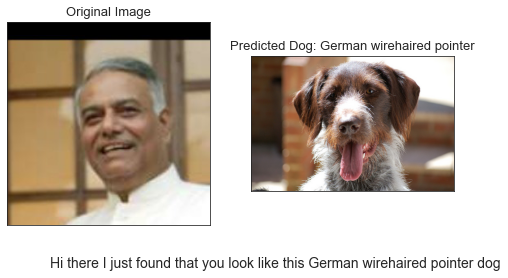

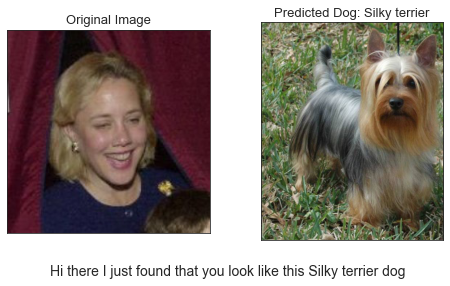

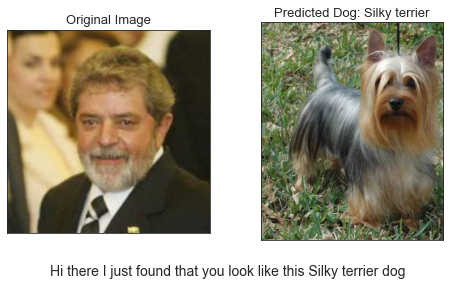

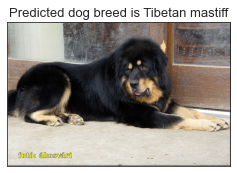

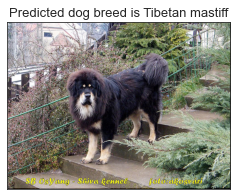

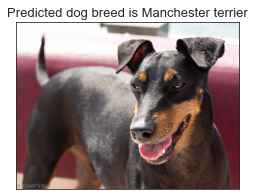

In [58]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
human_idx = np.random.randint(0, len(human_files), 3)
dog_idx = np.random.randint(0, len(dog_files), 3)
## suggested code, below
for file in np.hstack((human_files[human_idx], dog_files[dog_idx])):
    run_app(file)

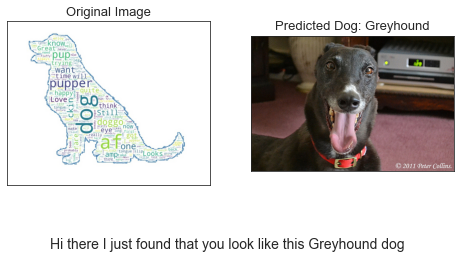

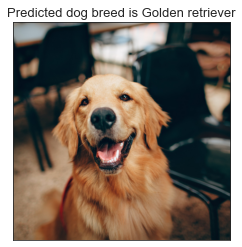

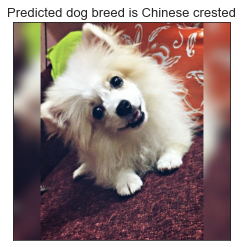

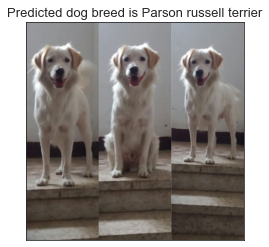

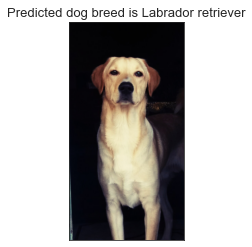

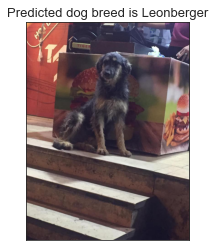

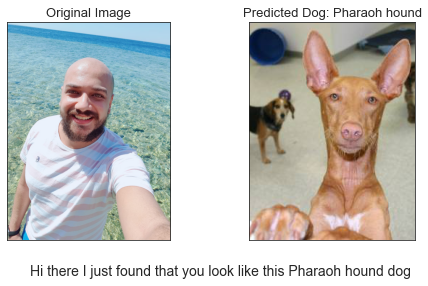

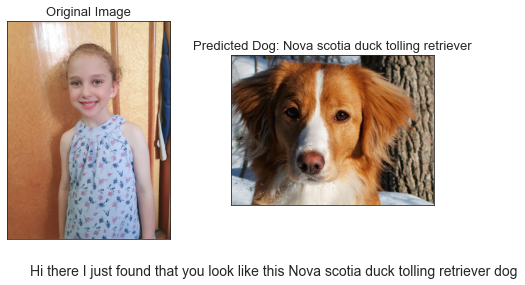

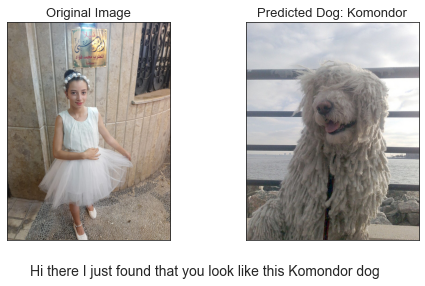

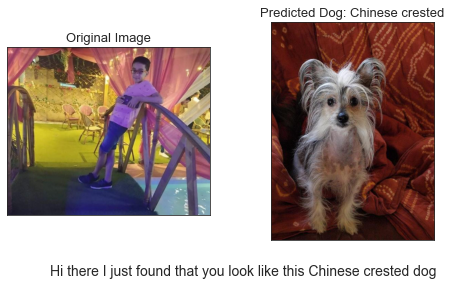

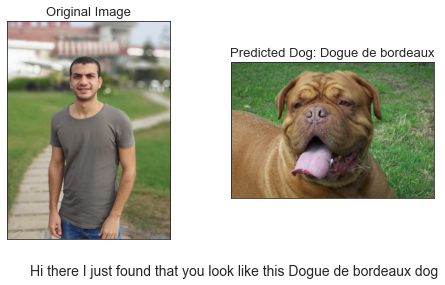

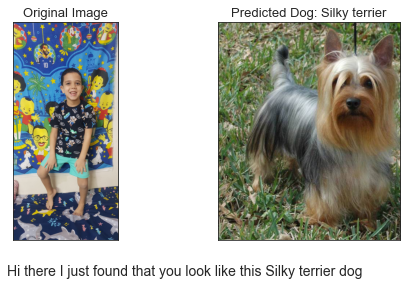

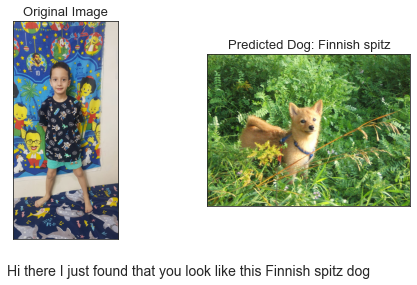

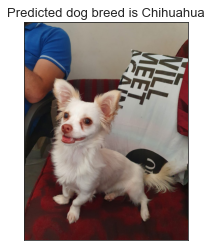

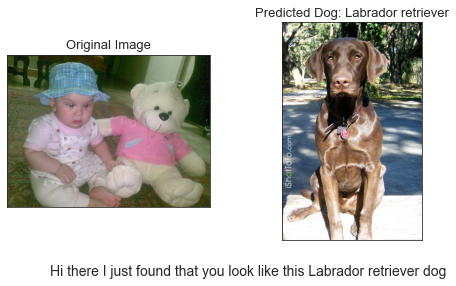

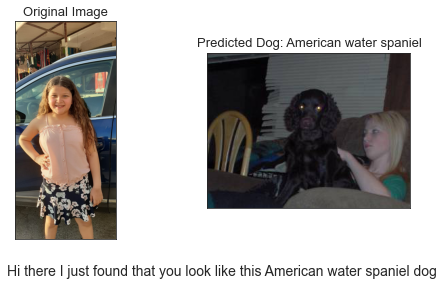

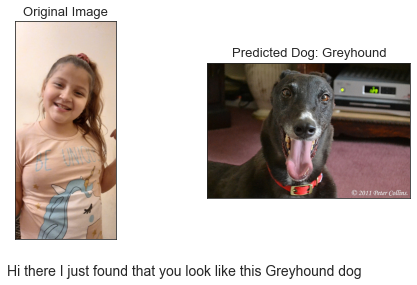

In [59]:
test_images = np.array(glob("my_test/*"))
for image in test_images:
    run_app(image)